In [1]:
import numpy as np

from collections import Counter, defaultdict
from itertools import cycle
from functools import partial

In [2]:
sample_size = 10000
products = ["A", "B", "C", "D"]
# totals = [10, 5, 15, 8]
totals = [10, 10, 10, 10]
lock = 21

In [3]:
# sequence 1
sequence1 = np.random.choice(products, size=sample_size).tolist()

# sequence 2
base = cycle(["A"]*20 + ["B"]*20 + ["C"]*20 + ["D"]*20)
sequence2 = list(dict(zip(range(sample_size), base)).values())

# sequence 3
base = cycle(["A"]*40 + ["B"]*40 + ["C"]*40 + ["D"]*40)
sequence3 = list(dict(zip(range(sample_size), base)).values())

In [4]:
assert len(sequence1) == sample_size
assert len(sequence2) == sample_size
assert len(sequence3) == sample_size

In [5]:
print(Counter(sequence1))
print(Counter(sequence2))
print(Counter(sequence3))

Counter({'A': 2539, 'B': 2529, 'D': 2467, 'C': 2465})
Counter({'A': 2500, 'B': 2500, 'C': 2500, 'D': 2500})
Counter({'A': 2520, 'B': 2520, 'C': 2480, 'D': 2480})


In [6]:
def no_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return machine_tuple[0]

def sum_of_product_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return sum(machine_tuple[1].values())

def product_count_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return machine_tuple[1][product]

def double_priority(machine_tuple, product=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return (machine_tuple[1][product], sum(machine_tuple[1].values()))

In [7]:
def simulate(
    num_of_machines,
    sequence,
    products,
    totals,
    lock,
    priority,
    reverse=True
):

    mix = dict(zip(products, totals))

    machines = {i: defaultdict(int) for i in range(num_of_machines)}
    
    flushes = defaultdict(int)

    trash = []

    for product in sequence:

        counter = 0
        for i, mach in sorted(machines.items(), key=partial(priority, product=product), reverse=reverse):
            
            counter += 1 

            # is the machine available and the product fits
            if machines[i][product] < mix[product] and machines[i]["lock"] == 0:
                machines[i][product] += 1
                break
            
            # is the machine unavailable
            if 0 < machines[i]["lock"]:
                machines[i]["lock"] -= 1
            
            # no machines are available
            if counter == len(machines):
                trash.append(product)
                break

        # check: clear machine
        for j in machines:
            if all(machines[j][p] == mix[p] for p in products):
                machines[j] = defaultdict(int)
                machines[j]["lock"] = lock
                flushes[j] += 1
    
    return {
        "trash": len(trash), 
        "total": len(sequence), 
        "consumed": len(sequence) - len(trash),
        "flushes": dict(flushes)
    }

In [8]:
print(simulate(5, sequence1, products, totals, lock, no_priority, reverse=False))
print(simulate(5, sequence2, products, totals, lock, no_priority, reverse=False))
print(simulate(5, sequence3, products, totals, lock, no_priority, reverse=False))
print()
print(simulate(5, sequence1, products, totals, lock, double_priority, reverse=True))
print(simulate(5, sequence2, products, totals, lock, double_priority, reverse=True))
print(simulate(5, sequence3, products, totals, lock, double_priority, reverse=True))

{'trash': 578, 'total': 10000, 'consumed': 9422, 'flushes': {0: 132, 1: 55, 2: 25, 3: 13, 4: 8}}
{'trash': 140, 'total': 10000, 'consumed': 9860, 'flushes': {0: 111, 1: 86, 2: 30, 3: 12, 4: 6}}
{'trash': 562, 'total': 10000, 'consumed': 9438, 'flushes': {0: 71, 1: 62, 2: 53, 3: 35, 4: 13}}

{'trash': 847, 'total': 10000, 'consumed': 9153, 'flushes': {0: 46, 1: 46, 2: 46, 3: 45, 4: 45}}
{'trash': 809, 'total': 10000, 'consumed': 9191, 'flushes': {0: 46, 1: 46, 2: 46, 3: 46, 4: 45}}
{'trash': 1110, 'total': 10000, 'consumed': 8890, 'flushes': {0: 45, 1: 45, 2: 45, 3: 43, 4: 42}}


In [9]:
def averages_of_simulations(num_of_machines, sequence, products, totals, lock, priority, reverse):
    simulations = 5

    rates = []

    for _ in range(simulations):
        data = simulate(num_of_machines, sequence, products, totals, lock, priority, reverse)
        rates.append(data["consumed"]/data["total"])
        
    return np.mean(rates)

In [10]:
x = range(1, 15, 1)

def get_the_ys(seq):
    return (
    [averages_of_simulations(xx, seq, products, totals, lock, no_priority, reverse=False) for xx in x],
#     [averages_of_simulations(xx, seq, products, totals, lock, sum_of_product_priority, reverse=True) for xx in x],
#     [averages_of_simulations(xx, seq, products, totals, lock, product_count_priority, reverse=True) for xx in x],
    [averages_of_simulations(xx, seq, products, totals, lock, sum_of_product_priority, reverse=True) for xx in x],
    )

# y1 = get_the_ys(sequence1)
# y2 = get_the_ys(sequence2)
# y3 = get_the_ys(sequence3)

In [11]:
from joblib import Parallel, delayed

results = Parallel(n_jobs=3)(delayed(get_the_ys)(i) for i in [sequence1, sequence2, sequence3])

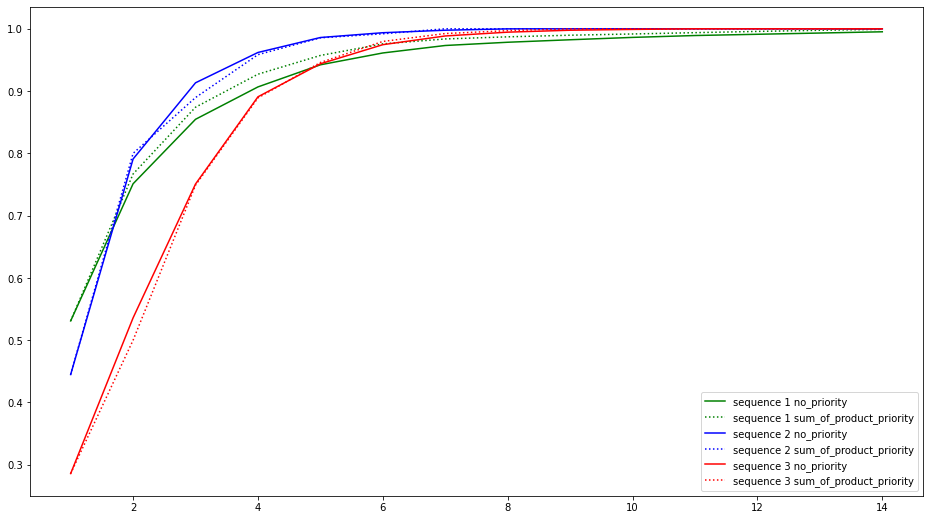

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

plt.plot(x, results[0][0], "-g", label="sequence 1 no_priority")
# plt.plot(x, results[0][1], "--g", label="sequence 1 sum_of_product_priority")
# plt.plot(x, results[0][2], "-.g", label="sequence 1 product_count_priority")
# plt.plot(x, results[0][3], ":g", label="sequence 1 double_priority")
plt.plot(x, results[0][1], ":g", label="sequence 1 sum_of_product_priority")

plt.plot(x, results[1][0], "-b", label="sequence 2 no_priority")
# plt.plot(x, results[1][1], "--b", label="sequence 2 sum_of_product_priority")
# plt.plot(x, results[1][2], "-.b", label="sequence 2 product_count_priority")
# plt.plot(x, results[1][3], ":b", label="sequence 2 double_priority")
plt.plot(x, results[1][1], ":b", label="sequence 2 sum_of_product_priority")

plt.plot(x, results[2][0], "-r", label="sequence 3 no_priority")
# plt.plot(x, results[2][1], "--r", label="sequence 3 sum_of_product_priority")
# plt.plot(x, results[2][2], "-.r", label="sequence 3 product_count_priority")
# plt.plot(x, results[2][3], ":r", label="sequence 3 double_priority")
plt.plot(x, results[2][1], ":r", label="sequence 3 sum_of_product_priority")

plt.legend()
plt.show()